# Predict XRF Minerology from wireline logs

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn
!pip install scikit-learn --upgrade

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datetime, os

import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, max_error, median_absolute_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.6.0


### Get the data
First download and import the dataset using pandas:

In [4]:
df3 = pd.read_csv('drive/My Drive/1_lewis_research/core_to_wl_merge/OS2_Merged_dataset_imputed_08_23_2021.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
raw_dataset = df3

In [6]:
raw_dataset.describe()

,Unnamed: 0,depth_ft,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,PE_smooth,GR_smooth,Unnamed: 0.1,gz_linear_interp,gz_pchip_interp,perm_air_md,perm_klink_md,He_por,API,horz_perm_md,effective_por,por_percent,stress_swanson_perm_md,sample_num,Na,Na Err,Mg,Mg Err,Al,Al Err,Si,Si Err,P,P Err,S,S Err,K,K Err,Ca,Ca Err,Ti,Ti Err,Cr,Cr Err,Mn,Mn Err,Fe,Fe Err,Co,Co Err,Ni,Ni Err,Cu,Cu Err,Zn,Zn Err,Ba,Ba Err,ScanTime1,LiveTime1,ScanTime2,LiveTime2
count,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,12030.000000,508.000000,510.000000,510.000000,4.060000e+02,25.000000,25.000000,24.000000,24.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.0,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,6014.500000,5395.933483,0.466556,0.328326,0.429381,0.811148,0.614137,0.349740,1.016212,0.170662,0.170662,0.350037,0.328327,6014.500000,4.913576,4.910244,81.002187,73.797216,14.267039,4.903546e+09,8.304000,11.808000,8.420833,1.646585,1502.571369,1.132042,0.025387,0.762913,0.011739,3.490170,0.012272,32.981494,0.033185,0.048516,0.001821,0.728955,0.002247,1.675288,0.005710,2.779623,0.005543,0.190546,0.001373,0.005787,0.000116,0.016520,0.000705,1.941109,0.003196,0.001315,0.0,0.004773,0.000100,0.003211,0.000822,0.006309,0.000763,0.090289,0.004689,34.080968,23.788815,51.598497,35.852170
std,3472.906204,5107.946027,0.194416,0.235920,0.263912,0.157662,0.214154,0.187045,1.483254,0.223275,0.223275,0.179438,0.227953,3472.906204,1.738128,1.751499,173.917355,161.251984,9.365678,7.086663e+05,3.161814,4.446902,3.050728,3.741652,775.504347,0.777851,0.004405,0.488501,0.002843,1.415185,0.002607,4.940991,0.002003,0.023636,0.000221,0.795110,0.001252,0.761818,0.001383,2.045850,0.002189,0.088087,0.000297,0.002270,0.000075,0.024982,0.000128,1.472163,0.001193,0.000821,0.0,0.000796,0.000002,0.004429,0.000114,0.004559,0.000100,0.065308,0.000594,10.363302,6.711722,21.025958,14.844795
min,0.000000,146.800000,0.000000,0.000000,0.003752,0.039257,0.000000,0.000000,-0.744314,0.000570,0.000570,0.004477,0.000258,0.000000,1.204296,1.199972,0.001000,0.000000,1.000000,4.900722e+09,1.900000,5.900000,4.000000,0.000390,4.000000,0.126200,0.016000,0.047000,0.006800,0.992200,0.007100,8.429500,0.021700,0.000000,0.001100,0.040300,0.000600,0.118400,0.002000,0.133500,0.001400,0.048500,0.000800,0.000000,-0.001200,0.000000,0.000500,0.270700,0.001300,0.000200,0.0,0.002700,0.000100,0.000000,0.000200,0.000000,0.000500,0.000000,0.003100,-1.000000,-1.000000,-1.000000,-1.000000
25%,3007.250000,447.525000,0.357945,0.127740,0.172052,0.746427,0.423621,0.213038,-0.044070,0.004603,0.004603,0.218002,0.137435,3007.250000,3.538724,3.531571,0.040750,0.020250,8.300000,4.903723e+09,7.900000,8.400000,6.800000,0.001140,869.750000,0.768500,0.023400,0.293850,0.009100,2.411025,0.010200,29.728050,0.032000,0.032400,0.001700,0.182225,0.001200,1.069725,0.004600,1.103025,0.003600,0.121875,0.001100,0.004400,0.000100,0.003200,0.000600,0.964250,0.002300,0.000700,0.0,0.004300,0.000100,0.000000,0.000700,0.002700,0.000700,0.053200,0.004300,30.000000,20.910000,60.000000,39.550000
50%,6014.500000,1607.050000,0.554827,0.276292,0.467492,0.863763,0.605414,0.323156,0.807921,0.005575,0.005575,0.328866,0.284592,6014.500000,4.307541,4.256191,0.065500,0.037500,9.300000,4.903723e+09,9.500000,10.600000,7.300000,0.002070,1524.500000,1.057300,0.025200,0.692000,0.011700,3.133250,0.011700,31.893100,0.033300,0.047250,0.001800,0.461450,0.001900,1.560450,0.005800,2.593250,0.005700,0.160300,0.001300,0.005400,0.000100,0.014200,0.000700,1.658800,0.

In [7]:
raw_dataset2 = raw_dataset[['CAL', 'GR', 'DT','SP','DENS','PE','RESD',
                            'PHIN','PHID','GR_smooth','PE_smooth', 
                            'Ti', 'Mg', 'Si', 'Al', 'Ca']]

In [8]:
dataset = raw_dataset2.copy()
dataset.tail()

,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,Ti,Mg,Si,Al,Ca
12025,0.080749,0.763390,0.318322,0.502314,0.628529,0.428994,-0.163882,0.378053,0.378053,0.766522,0.471810,0.1207,0.5084,35.4358,1.8027,4.3886
12026,0.080822,0.767160,0.319374,0.501919,0.636449,0.432019,-0.152552,0.369177,0.369177,0.767302,0.477121,NaN,NaN,NaN,NaN,NaN
12027,0.080896,0.769669,0.321289,0.501597,0.647342,0.435815,-0.141083,0.360357,0.360357,0.768093,0.482966,NaN,NaN,NaN,NaN,NaN
12028,0.080966,0.770943,0.323205,0.501896,0.659338,0.439788,-0.129482,0.351481,0.351481,0.768893,0.489439,NaN,NaN,NaN,NaN,NaN
12029,0.081035,0.771780,0.325120,0.502990,0.671133,0.442261,-0.117661,0.342605,0.342605,0.769668,0.496650,NaN,NaN,NaN,NaN,NaN


### Clean the data

The dataset contains a few unknown values.

In [9]:
dataset.isna().sum()

CAL             0
GR              0
DT              0
SP              0
DENS            0
PE              0
RESD            0
PHIN            0
PHID            0
GR_smooth       0
PE_smooth       0
Ti           9634
Mg           9634
Si           9634
Al           9634
Ca           9634
dtype: int64

Drop those rows to keep this simple.

In [10]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [11]:
train_dataset = dataset.sample(frac=0.75, random_state=0)

test_dataset = dataset.drop(train_dataset.index)

In [12]:
test_dataset

,CAL,GR,DT,SP,DENS,PE,RESD,PHIN,PHID,GR_smooth,PE_smooth,Ti,Mg,Si,Al,Ca
0,0.595503,0.167502,0.042458,0.590006,0.831504,0.334348,1.285381,0.001736,0.001736,0.192619,0.374193,0.1641,0.6987,33.9921,2.8101,4.5640
15,0.601650,0.144855,0.064707,0.577475,0.832983,0.349277,1.699624,0.001722,0.001722,0.159450,0.349904,0.1299,0.7452,33.8530,2.5535,3.7321
35,0.596920,0.222889,0.048480,0.607500,0.854984,0.355921,1.044717,0.001307,0.001307,0.209110,0.353898,0.1981,0.7058,34.6223,2.4844,4.0587
105,0.468022,0.277766,0.068289,0.681399,0.886342,0.415254,0.383399,0.001250,0.001250,0.256894,0.403479,0.1847,1.0891,28.2121,2.9206,8.8570
120,0.443424,0.244354,0.017134,0.698529,0.886641,0.433869,0.662305,0.001274,0.001274,0.260143,0.400272,0.1631,1.1419,33.3083,2.7980,4.7349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11895,0.078067,0.437203,0.408380,0.396010,0.296822,0.354506,1.089013,0.708786,0.708786,0.426899,0.369870,0.1070,0.3080,41.5003,1.1553,1.8917
11935,0.075074,0.388744,0.379712,0.444216,0.380426,0.454697,0.210972,0.621325,0.621325,0.420678,0.490159,0.0913,0.2007,39.5778,1.2188,2.2226
11965,0.076368,0.626626,0.575092,0.475624,0.609917,0.535526,-0.029156,0.393204,0.393204,0.621159,0.549755,0.2136,0.7811,35.0960,3.3459,2.6910
11975,0.077098,0.589074,0.574626,0.483627,0.618004,0.483593,-0.172343,0.380993,0.380993,0.616604,0.488366,0.0694,0.3117,38.4735,1.4931,2.0920


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

In [13]:
sns.pairplot(train_dataset[['PE', 'PE_smooth', 'GR_smooth', 
                            'DT', 'RESD','DENS','PHID', 'GR',
                            'Ti', 'Mg', 'Si', 'Al', 'Ca']], diag_kind='kde')

Output hidden; open in https://colab.research.google.com to view.

Also look at the overall statistics, note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAL,1797.0,0.463482,0.193665,0.000000,0.360835,0.553169,0.602322,0.893965
GR,1797.0,0.325359,0.235913,0.000000,0.127280,0.273285,0.522829,1.000000
DT,1797.0,0.426683,0.264164,0.003880,0.171729,0.456420,0.661612,0.962645
SP,1797.0,0.807760,0.159818,0.126147,0.738639,0.862806,0.922202,0.999854
DENS,1797.0,0.614393,0.217677,0.000702,0.420504,0.608273,0.831951,0.953937
PE,1797.0,0.349186,0.184980,0.001309,0.216698,0.323913,0.464252,0.966990
RESD,1797.0,1.013596,1.440046,-0.743339,-0.024775,0.817864,1.402560,8.890079
PHIN,1797.0,0.173910,0.227192,0.000664,0.004588,0.005628,0.341629,1.000000
PHID,1797.0,0.173910,0.227192,0.000664,0.004588,0.005628,0.341629,1.000000
GR_smooth,1797.0,0.325159,0.228019,0.001737,0.133764,0.281937,0.512157,1.000000


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [15]:
test_features2 = test_dataset.copy()
test_features = test_features2[['PE', 'PE_smooth', 'GR_smooth', 
                                'DT', 'RESD','DENS','PHID', 'GR']]

train_features2 = train_dataset.copy()
train_features = train_features2[['PE', 'PE_smooth', 'GR_smooth', 
                                'DT', 'RESD','DENS','PHID', 'GR']]

train_labels = train_dataset[['Ti', 'Mg', 'Si', 'Al', 'Ca']]
test_labels = test_features2[['Ti', 'Mg', 'Si', 'Al', 'Ca']]

In [16]:
input_dimm = np.size(test_features.columns)
print('input neurons', input_dimm)

output_dimm = np.size(test_labels.columns)
print('output neurons', output_dimm)

input neurons 8
output neurons 5


## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [17]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CAL,0.463482,0.193665
GR,0.325359,0.235913
DT,0.426683,0.264164
SP,0.807760,0.159818
DENS,0.614393,0.217677
PE,0.349186,0.184980
RESD,1.013596,1.440046
PHIN,0.173910,0.227192
PHID,0.173910,0.227192
GR_smooth,0.325159,0.228019


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [18]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [19]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [20]:
print(normalizer.mean.numpy())

[[0.349 0.35  0.325 0.427 1.014 0.614 0.174 0.325]]


When the layer is called it returns the input data, with each feature independently normalized:

In [21]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[0.57 0.62 0.14 0.55 0.01 0.57 0.   0.19]]

Normalized: [[ 1.21  1.52 -0.8   0.46 -0.7  -0.21 -0.75 -0.58]]


### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [22]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [23]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(12, input_dim=input_dimm, activation='relu', # 16 (32 is a step too far?)
                   activity_regularizer=tf.keras.regularizers.L2(0.01)), 
      layers.Dropout(.10), # Maybe not needed with sensiable choices
      layers.Dense(24, activation='relu',  # 32
                   activity_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01)), 
      layers.Dense(output_dimm) # number of output minerals
  ])

  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [24]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125       
Total params: 562
Trainable params: 545
Non-trainable params: 17
_________________________________________________________________


In [25]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=200, 
    callbacks=[early_stop])

CPU times: user 14.5 s, sys: 1.32 s, total: 15.8 s
Wall time: 12.6 s


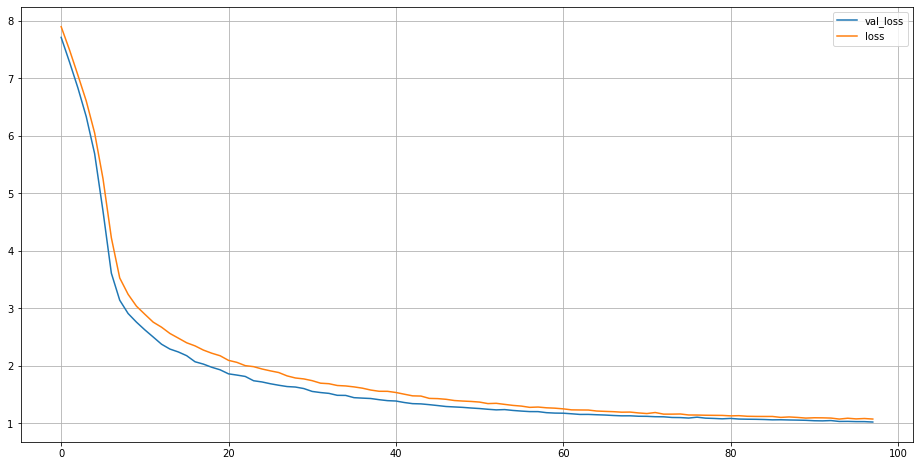

In [26]:
plt.figure(figsize=(16,8))
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label='loss')
plt.grid(True)
plt.legend()

In [27]:
rmse = mean_squared_error(np.array(history.history['loss']), (history.history['val_loss']))

(-0.75, 0.75)

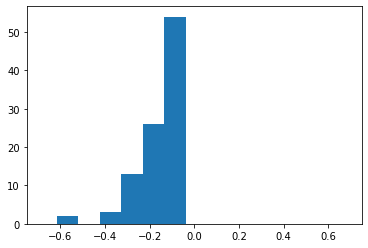

In [28]:
plt.hist((np.array(history.history['val_loss'])-np.array(history.history['loss'])), bins=6)
plt.xlim(-0.75, 0.75)


In [29]:
test_features

,PE,PE_smooth,GR_smooth,DT,RESD,DENS,PHID,GR
0,0.334348,0.374193,0.192619,0.042458,1.285381,0.831504,0.001736,0.167502
15,0.349277,0.349904,0.159450,0.064707,1.699624,0.832983,0.001722,0.144855
35,0.355921,0.353898,0.209110,0.048480,1.044717,0.854984,0.001307,0.222889
105,0.415254,0.403479,0.256894,0.068289,0.383399,0.886342,0.001250,0.277766
120,0.433869,0.400272,0.260143,0.017134,0.662305,0.886641,0.001274,0.244354
...,...,...,...,...,...,...,...,...
11895,0.354506,0.369870,0.426899,0.408380,1.089013,0.296822,0.708786,0.437203
11935,0.454697,0.490159,0.420678,0.379712,0.210972,0.380426,0.621325,0.388744
11965,0.535526,0.549755,0.621159,0.575092,-0.029156,0.609917,0.393204,0.626626
11975,0.483593,0.488366,0.616604,0.574626,-0.172343,0.618004,0.380993,0.589074


In [30]:
test_labels

,Ti,Mg,Si,Al,Ca
0,0.1641,0.6987,33.9921,2.8101,4.5640
15,0.1299,0.7452,33.8530,2.5535,3.7321
35,0.1981,0.7058,34.6223,2.4844,4.0587
105,0.1847,1.0891,28.2121,2.9206,8.8570
120,0.1631,1.1419,33.3083,2.7980,4.7349
...,...,...,...,...,...
11895,0.1070,0.3080,41.5003,1.1553,1.8917
11935,0.0913,0.2007,39.5778,1.2188,2.2226
11965,0.2136,0.7811,35.0960,3.3459,2.6910
11975,0.0694,0.3117,38.4735,1.4931,2.0920


Collect the results on the test set:

In [31]:
dnn_model.evaluate(test_features, test_labels, verbose=0)

1.047635793685913

In [32]:
test_predictions = dnn_model.predict(test_features)

In [33]:
test_labels.values

array([[ 0.164,  0.699, 33.992,  2.81 ,  4.564],
       [ 0.13 ,  0.745, 33.853,  2.554,  3.732],
       [ 0.198,  0.706, 34.622,  2.484,  4.059],
       ...,
       [ 0.214,  0.781, 35.096,  3.346,  2.691],
       [ 0.069,  0.312, 38.474,  1.493,  2.092],
       [ 0.375,  1.095, 30.195,  5.413,  2.933]])

In [34]:
test_predictions

array([[ 0.154,  0.76 , 34.332,  2.807,  3.399],
       [ 0.144,  0.664, 34.004,  2.599,  3.368],
       [ 0.158,  0.769, 33.774,  2.947,  3.248],
       ...,
       [ 0.273,  0.994, 31.141,  4.962,  2.065],
       [ 0.275,  1.017, 30.941,  4.962,  2.185],
       [ 0.305,  1.009, 31.038,  5.368,  1.973]], dtype=float32)

In [35]:
rmse = mean_squared_error(test_labels.values, test_predictions, squared=False)
print("Mean Squared Error: %f" % (rmse))

MAE = median_absolute_error(test_labels.values, test_predictions)
print("Median Absolute Error: %f" % (MAE))

Mean Squared Error: 1.250410
Median Absolute Error: 0.439743


# Export

In [36]:
x = datetime.datetime.now()

d = {'target': ['MultiXRF'],
     'MSE': [rmse],
     'MAE': [MAE],
     'day': [x.day], 
     'month':[ x.month], 
     'year':[x.year],
     'model':['DNN'],
     'version':[tf.__version__]}

results = pd.DataFrame(data=d)

results.to_csv('drive/My Drive/1_lewis_research/analysis/experiments/dnn/dnn_results/OS2_multi_XRF_DNN.csv')

results

,target,MSE,MAE,day,month,year,model,version
0,MultiXRF,1.25041,0.439743,25,8,2021,DNN,2.6.0


## Performance

Now that all the models are trained check the test-set performance and see how they did:

These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

In [37]:
test_predictions = dnn_model.predict(test_features)

In [38]:
test_predictions

array([[ 0.154,  0.76 , 34.332,  2.807,  3.399],
       [ 0.144,  0.664, 34.004,  2.599,  3.368],
       [ 0.158,  0.769, 33.774,  2.947,  3.248],
       ...,
       [ 0.273,  0.994, 31.141,  4.962,  2.065],
       [ 0.275,  1.017, 30.941,  4.962,  2.185],
       [ 0.305,  1.009, 31.038,  5.368,  1.973]], dtype=float32)

In [39]:
test_labels.values

array([[ 0.164,  0.699, 33.992,  2.81 ,  4.564],
       [ 0.13 ,  0.745, 33.853,  2.554,  3.732],
       [ 0.198,  0.706, 34.622,  2.484,  4.059],
       ...,
       [ 0.214,  0.781, 35.096,  3.346,  2.691],
       [ 0.069,  0.312, 38.474,  1.493,  2.092],
       [ 0.375,  1.095, 30.195,  5.413,  2.933]])

In [40]:
new_array = test_labels.values - test_predictions

In [41]:
df = pd.DataFrame(data=new_array, columns = test_labels.columns)
df

,Ti,Mg,Si,Al,Ca
0,0.009719,-0.061475,-0.339660,0.003572,1.164549
1,-0.014427,0.080774,-0.150963,-0.045107,0.364171
2,0.040520,-0.062950,0.848359,-0.462606,0.810747
3,0.017304,0.197500,-5.042321,-0.324709,5.705908
4,-0.002825,0.251941,0.094822,-0.360145,1.400473
...,...,...,...,...,...
594,-0.030831,0.013598,6.738017,-1.773369,0.439504
595,-0.073313,-0.307335,5.371310,-2.135591,0.517792
596,-0.059030,-0.213058,3.955461,-1.616527,0.626263
597,-0.205226,-0.705419,7.532572,-3.468590,-0.092774


In [42]:
df.describe(percentiles=[0.10,0.90])

,Ti,Mg,Si,Al,Ca
count,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.012062,0.045364,-0.356226,0.090964,0.421598
std,0.062465,0.260248,3.207705,0.902132,1.745015
min,-0.214739,-0.706635,-21.380515,-4.097248,-1.787808
10%,-0.036829,-0.208217,-3.842649,-0.763469,-0.732074
50%,0.002782,0.010598,0.166761,0.032772,-0.012820
90%,0.068397,0.312973,2.563923,0.855725,1.640716
max,0.501990,1.358315,8.745959,5.825721,11.632270


(array([  6.,  13., 254., 271.,  34.,  13.,   5.,   1.,   0.,   2.]),
 array([-0.215, -0.143, -0.071,  0.   ,  0.072,  0.144,  0.215,  0.287,
         0.359,  0.43 ,  0.502]),
 <a list of 10 Patch objects>)

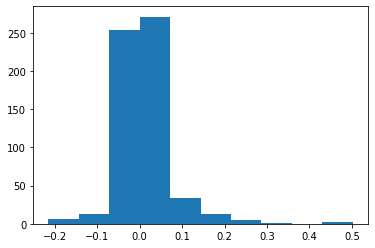

In [43]:
plt.hist(df.Ti)

It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

In [44]:
test_predictions

array([[ 0.154,  0.76 , 34.332,  2.807,  3.399],
       [ 0.144,  0.664, 34.004,  2.599,  3.368],
       [ 0.158,  0.769, 33.774,  2.947,  3.248],
       ...,
       [ 0.273,  0.994, 31.141,  4.962,  2.065],
       [ 0.275,  1.017, 30.941,  4.962,  2.185],
       [ 0.305,  1.009, 31.038,  5.368,  1.973]], dtype=float32)

If you're happy with the model save it for later use:

In [45]:
dnn_model.save('dnn_model.h5')

If you reload the model, it gives identical output:

In [46]:
#reloaded = tf.keras.models.load_model('dnn_model')

#test_results['reloaded'] = reloaded.evaluate(
#    test_features, test_labels, verbose=0)